In [1]:
%%time
%matplotlib inline
from datetime import datetime, timedelta
import time
import os
import boto3
import re
import json
from sagemaker import get_execution_role, session
from sagemaker.s3 import S3Downloader, S3Uploader

region = boto3.Session().region_name
role = get_execution_role()
sm_session = session.Session(boto3.Session())
sm = boto3.Session().client("sagemaker")
sm_runtime = boto3.Session().client("sagemaker-runtime")

# You can use a different bucket, but make sure the role you chose for this notebook
# has the s3:PutObject permissions. This is the bucket into which the model artifacts will be uploaded
bucket = sm_session.default_bucket()
prefix = "sagemaker/DEMO-VariantTargeting"

Matplotlib is building the font cache; this may take a moment.


CPU times: user 2.28 s, sys: 292 ms, total: 2.57 s
Wall time: 43.9 s


In [11]:
model_url = S3Uploader.upload(
    local_path="model/xgb-churn-prediction-model.tar.gz", desired_s3_uri=f"s3://{bucket}/{prefix}"
)
model_url2 = S3Uploader.upload(
    local_path="model/xgb-churn-prediction-model2.tar.gz", desired_s3_uri=f"s3://{bucket}/{prefix}"
)
model_url, model_url2

('s3://sagemaker-us-west-1-167762637358/sagemaker/DEMO-VariantTargeting/xgb-churn-prediction-model.tar.gz',
 's3://sagemaker-us-west-1-167762637358/sagemaker/DEMO-VariantTargeting/xgb-churn-prediction-model2.tar.gz')

In [12]:
from sagemaker.image_uris import retrieve


model_name = f"DEMO-xgb-churn-pred-{datetime.now():%Y-%m-%d-%H-%M-%S}"
model_name2 = f"DEMO-xgb-churn-pred2-{datetime.now():%Y-%m-%d-%H-%M-%S}"
image_uri = retrieve("xgboost", boto3.Session().region_name, "0.90-1")
image_uri2 = retrieve("xgboost", boto3.Session().region_name, "0.90-2")

sm_session.create_model(
    name=model_name, role=role, container_defs={"Image": image_uri, "ModelDataUrl": model_url}
)

sm_session.create_model(
    name=model_name2, role=role, container_defs={"Image": image_uri2, "ModelDataUrl": model_url2}
)

'DEMO-xgb-churn-pred2-2022-08-29-18-52-05'

In [13]:
from sagemaker.session import production_variant

variant1 = production_variant(
    model_name=model_name,
    instance_type="ml.m5.xlarge",
    initial_instance_count=1,
    variant_name="Variant1",
    initial_weight=1,
)
variant2 = production_variant(
    model_name=model_name2,
    instance_type="ml.m5.xlarge",
    initial_instance_count=1,
    variant_name="Variant2",
    initial_weight=1,
)

(variant1, variant2)

({'ModelName': 'DEMO-xgb-churn-pred-2022-08-29-18-52-05',
  'VariantName': 'Variant1',
  'InitialVariantWeight': 1,
  'InitialInstanceCount': 1,
  'InstanceType': 'ml.m5.xlarge'},
 {'ModelName': 'DEMO-xgb-churn-pred2-2022-08-29-18-52-05',
  'VariantName': 'Variant2',
  'InitialVariantWeight': 1,
  'InitialInstanceCount': 1,
  'InstanceType': 'ml.m5.xlarge'})

In [14]:
endpoint_name = f"DEMO-xgb-churn-pred-{datetime.now():%Y-%m-%d-%H-%M-%S}"
print(f"EndpointName={endpoint_name}")

sm_session.endpoint_from_production_variants(
    name=endpoint_name, production_variants=[variant1, variant2]
)

EndpointName=DEMO-xgb-churn-pred-2022-08-29-18-52-10
-------------!

'DEMO-xgb-churn-pred-2022-08-29-18-52-10'

In [34]:
# get a subset of test data for a quick test
!tail -120 test_data/test-dataset-input-cols.csv > test_data/test_sample_tail_input_cols.csv
print(f"Sending test traffic to the endpoint {endpoint_name}. \nPlease wait...")

with open("test_data/test_sample_tail_input_cols.csv", "r") as f:
    for row in f:
        print(".", end="", flush=True)
        payload = row.rstrip("\n")
        sm_runtime.invoke_endpoint(EndpointName=endpoint_name, ContentType="text/csv", Body=payload)
        time.sleep(0.5)

print("Done!")

Sending test traffic to the endpoint DEMO-xgb-churn-pred-2022-08-29-18-52-10. 
Please wait...
........................................................................................................................Done!


In [35]:
import pandas as pd

cw = boto3.Session().client("cloudwatch")


def get_invocation_metrics_for_endpoint_variant(endpoint_name, variant_name, start_time, end_time):
    metrics = cw.get_metric_statistics(
        Namespace="AWS/SageMaker",
        MetricName="Invocations",
        StartTime=start_time,
        EndTime=end_time,
        Period=60,
        Statistics=["Sum"],
        Dimensions=[
            {"Name": "EndpointName", "Value": endpoint_name},
            {"Name": "VariantName", "Value": variant_name},
        ],
    )
    return (
        pd.DataFrame(metrics["Datapoints"])
        .sort_values("Timestamp")
        .set_index("Timestamp")
        .drop("Unit", axis=1)
        .rename(columns={"Sum": variant_name})
    )


def plot_endpoint_metrics(start_time=None):
    start_time = start_time or datetime.now() - timedelta(minutes=60)
    end_time = datetime.now()
    metrics_variant1 = get_invocation_metrics_for_endpoint_variant(
        endpoint_name, variant1["VariantName"], start_time, end_time
    )
    metrics_variant2 = get_invocation_metrics_for_endpoint_variant(
        endpoint_name, variant2["VariantName"], start_time, end_time
    )
    metrics_variants = metrics_variant1.join(metrics_variant2, how="outer")
    metrics_variants.plot()
    return metrics_variants

Waiting a minute for initial metric creation...


,Variant1,Variant2
Timestamp,,
2022-08-29 19:37:00+00:00,0.0,0.0
2022-08-29 19:38:00+00:00,0.0,0.0
2022-08-29 19:39:00+00:00,0.0,0.0
2022-08-29 19:40:00+00:00,0.0,0.0
2022-08-29 19:41:00+00:00,0.0,0.0
2022-08-29 19:42:00+00:00,0.0,0.0
2022-08-29 19:43:00+00:00,0.0,0.0
2022-08-29 19:44:00+00:00,0.0,0.0
2022-08-29 19:45:00+00:00,0.0,0.0


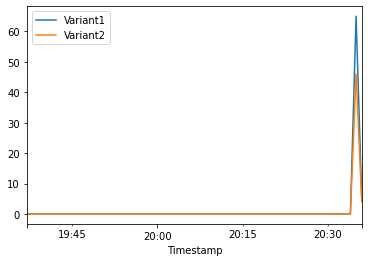

In [36]:
print("Waiting a minute for initial metric creation...")
time.sleep(60)
plot_endpoint_metrics()

In [37]:
import numpy as np

predictions = ""

print(f"Sending test traffic to the endpoint {endpoint_name}. \nPlease wait...")
with open("test_data/test_sample_tail_input_cols.csv", "r") as f:
    for row in f:
        print(".", end="", flush=True)
        payload = row.rstrip("\n")
        response = sm_runtime.invoke_endpoint(
            EndpointName=endpoint_name,
            ContentType="text/csv",
            Body=payload,
            TargetVariant=variant1["VariantName"],
        )
        predictions = ",".join([predictions, response["Body"].read().decode("utf-8")])
        time.sleep(0.5)

# Convert our predictions to a numpy array
pred_np = np.fromstring(predictions[1:], sep=",")

# Convert the prediction probabilities to binary predictions of either 1 or 0
threshold = 0.5
preds = np.where(pred_np > threshold, 1, 0)
print("Done!")

Sending test traffic to the endpoint DEMO-xgb-churn-pred-2022-08-29-18-52-10. 
Please wait...
........................................................................................................................Done!


,Variant1,Variant2
Timestamp,,
2022-08-29 19:38:00+00:00,0.0,0.0
2022-08-29 19:39:00+00:00,0.0,0.0
2022-08-29 19:40:00+00:00,0.0,0.0
2022-08-29 19:41:00+00:00,0.0,0.0
2022-08-29 19:42:00+00:00,0.0,0.0
2022-08-29 19:43:00+00:00,0.0,0.0
2022-08-29 19:44:00+00:00,0.0,0.0
2022-08-29 19:45:00+00:00,0.0,0.0
2022-08-29 19:46:00+00:00,0.0,0.0


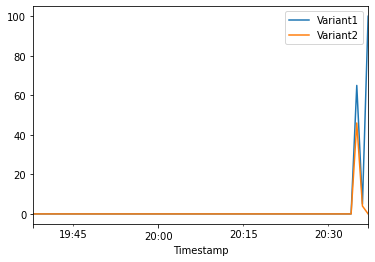

In [38]:
time.sleep(20)  # let metrics catch up
plot_endpoint_metrics()

Accuracy: 0.9583333333333334
Precision: 0.9411764705882353
Recall: 0.8
F1 Score: 0.8648648648648648
AUC is 0.895


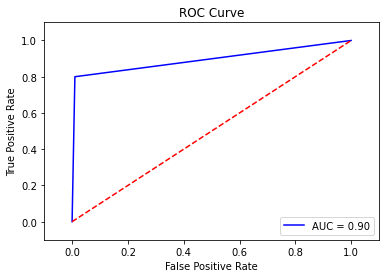

In [39]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
from sklearn.metrics import roc_auc_score

# Let's get the labels of our test set; we will use these to evaluate our predictions
!tail -121 test_data/test-dataset.csv > test_data/test_dataset_sample_tail.csv
df_with_labels = pd.read_csv("test_data/test_dataset_sample_tail.csv")
test_labels = df_with_labels.iloc[:, 0]
labels = test_labels.to_numpy()

# Calculate accuracy
accuracy = sum(preds == labels) / len(labels)
print(f"Accuracy: {accuracy}")

# Calculate precision
precision = sum(preds[preds == 1] == labels[preds == 1]) / len(preds[preds == 1])
print(f"Precision: {precision}")

# Calculate recall
recall = sum(preds[preds == 1] == labels[preds == 1]) / len(labels[labels == 1])
print(f"Recall: {recall}")

# Calculate F1 score
f1_score = 2 * (precision * recall) / (precision + recall)
print(f"F1 Score: {f1_score}")

# Calculate AUC
auc = round(roc_auc_score(labels, preds), 4)
print("AUC is " + repr(auc))

fpr, tpr, _ = metrics.roc_curve(labels, preds)

plt.title("ROC Curve")
plt.plot(fpr, tpr, "b", label="AUC = %0.2f" % auc)
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

In [40]:
predictions2 = ""
print(f"Sending test traffic to the endpoint {endpoint_name}. \nPlease wait...")
with open("test_data/test_sample_tail_input_cols.csv", "r") as f:
    for row in f:
        print(".", end="", flush=True)
        payload = row.rstrip("\n")
        response = sm_runtime.invoke_endpoint(
            EndpointName=endpoint_name,
            ContentType="text/csv",
            Body=payload,
            TargetVariant=variant2["VariantName"],
        )
        predictions2 = ",".join([predictions2, response["Body"].read().decode("utf-8")])
        time.sleep(0.5)

# Convert to numpy array
pred_np2 = np.fromstring(predictions2[1:], sep=",")

# Convert to binary predictions
thresh = 0.5
preds2 = np.where(pred_np2 > threshold, 1, 0)

print("Done!")


Sending test traffic to the endpoint DEMO-xgb-churn-pred-2022-08-29-18-52-10. 
Please wait...
........................................................................................................................Done!


,Variant1,Variant2
Timestamp,,
2022-08-29 19:40:00+00:00,0.0,0.0
2022-08-29 19:41:00+00:00,0.0,0.0
2022-08-29 19:42:00+00:00,0.0,0.0
2022-08-29 19:43:00+00:00,0.0,0.0
2022-08-29 19:44:00+00:00,0.0,0.0
2022-08-29 19:45:00+00:00,0.0,0.0
2022-08-29 19:46:00+00:00,0.0,0.0
2022-08-29 19:47:00+00:00,0.0,0.0
2022-08-29 19:48:00+00:00,0.0,0.0


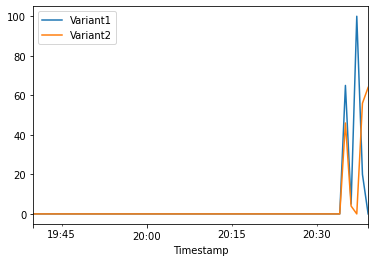

In [41]:
time.sleep(60)  # give metrics time to catch up
plot_endpoint_metrics()

Accuracy: 0.9583333333333334
Precision: 0.8947368421052632
Recall: 0.85
F1 Score: 0.8717948717948718
AUC is 0.915


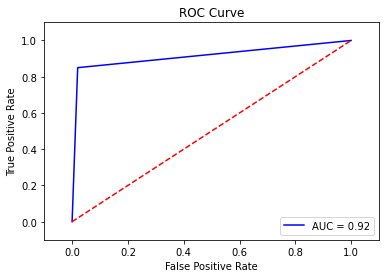

In [42]:
# Calculate accuracy
accuracy2 = sum(preds2 == labels) / len(labels)
print(f"Accuracy: {accuracy2}")

# Calculate precision
precision2 = sum(preds2[preds2 == 1] == labels[preds2 == 1]) / len(preds2[preds2 == 1])
print(f"Precision: {precision2}")

# Calculate recall
recall2 = sum(preds2[preds2 == 1] == labels[preds2 == 1]) / len(labels[labels == 1])
print(f"Recall: {recall2}")

# Calculate F1 score
f1_score2 = 2 * (precision2 * recall2) / (precision2 + recall2)
print(f"F1 Score: {f1_score2}")

auc2 = round(roc_auc_score(labels, preds2), 4)
print("AUC is " + repr(auc2))

fpr2, tpr2, _ = metrics.roc_curve(labels, preds2)

plt.title("ROC Curve")
plt.plot(fpr2, tpr2, "b", label="AUC = %0.2f" % auc2)
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

In [43]:
{
    variant["VariantName"]: variant["CurrentWeight"]
    for variant in sm.describe_endpoint(EndpointName=endpoint_name)["ProductionVariants"]
}

{'Variant1': 1.0, 'Variant2': 1.0}

In [44]:
def invoke_endpoint_for_two_minutes():
    with open("test_data/test-dataset-input-cols.csv", "r") as f:
        for row in f:
            print(".", end="", flush=True)
            payload = row.rstrip("\n")
            response = sm_runtime.invoke_endpoint(
                EndpointName=endpoint_name, ContentType="text/csv", Body=payload
            )
            response["Body"].read()
            time.sleep(1)

..............................................................................................................................................................................................................................................................................................................................................

,Variant1,Variant2
Timestamp,,
2022-08-29 20:40:00+00:00,12.0,14.0
2022-08-29 20:41:00+00:00,30.0,29.0
2022-08-29 20:42:00+00:00,23.0,36.0
2022-08-29 20:43:00+00:00,28.0,32.0
2022-08-29 20:44:00+00:00,30.0,29.0
2022-08-29 20:45:00+00:00,14.0,17.0


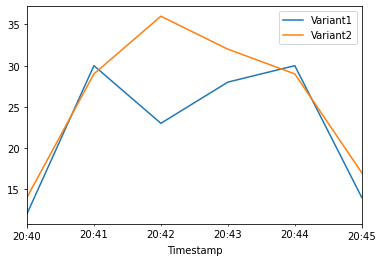

In [45]:
invocation_start_time = datetime.now()
invoke_endpoint_for_two_minutes()
time.sleep(20)  # give metrics time to catch up
plot_endpoint_metrics(invocation_start_time)

In [46]:
sm.update_endpoint_weights_and_capacities(
    EndpointName=endpoint_name,
    DesiredWeightsAndCapacities=[
        {"DesiredWeight": 25, "VariantName": variant1["VariantName"]},
        {"DesiredWeight": 75, "VariantName": variant2["VariantName"]},
    ],
)

{'EndpointArn': 'arn:aws:sagemaker:us-west-1:167762637358:endpoint/demo-xgb-churn-pred-2022-08-29-18-52-10',
 'ResponseMetadata': {'RequestId': '566d53fe-106f-43ff-b56a-58b44ef194d3',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '566d53fe-106f-43ff-b56a-58b44ef194d3',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '107',
   'date': 'Mon, 29 Aug 2022 20:46:33 GMT'},
  'RetryAttempts': 0}}

In [47]:
print("Waiting for update to complete")
while True:
    status = sm.describe_endpoint(EndpointName=endpoint_name)["EndpointStatus"]
    if status in ["InService", "Failed"]:
        print("Done")
        break
    print(".", end="", flush=True)
    time.sleep(1)

{
    variant["VariantName"]: variant["CurrentWeight"]
    for variant in sm.describe_endpoint(EndpointName=endpoint_name)["ProductionVariants"]
}

Waiting for update to complete
..........................................................Done


{'Variant1': 25.0, 'Variant2': 75.0}

..............................................................................................................................................................................................................................................................................................................................................

,Variant1,Variant2
Timestamp,,
2022-08-29 20:40:00+00:00,12.0,14.0
2022-08-29 20:41:00+00:00,30.0,29.0
2022-08-29 20:42:00+00:00,23.0,36.0
2022-08-29 20:43:00+00:00,28.0,32.0
2022-08-29 20:44:00+00:00,30.0,29.0
2022-08-29 20:45:00+00:00,34.0,25.0
2022-08-29 20:46:00+00:00,6.0,6.0
2022-08-29 20:47:00+00:00,5.0,20.0
2022-08-29 20:48:00+00:00,15.0,44.0


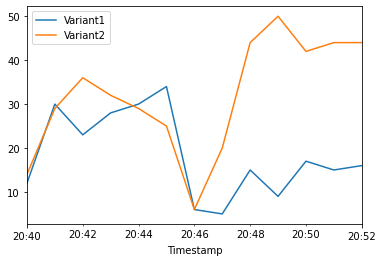

In [48]:
invoke_endpoint_for_two_minutes()
time.sleep(20)  # give metrics time to catch up
plot_endpoint_metrics(invocation_start_time)

In [49]:
sm.update_endpoint_weights_and_capacities(
    EndpointName=endpoint_name,
    DesiredWeightsAndCapacities=[
        {"DesiredWeight": 0, "VariantName": variant1["VariantName"]},
        {"DesiredWeight": 1, "VariantName": variant2["VariantName"]},
    ],
)
print("Waiting for update to complete")
while True:
    status = sm.describe_endpoint(EndpointName=endpoint_name)["EndpointStatus"]
    if status in ["InService", "Failed"]:
        print("Done")
        break
    print(".", end="", flush=True)
    time.sleep(1)

{
    variant["VariantName"]: variant["CurrentWeight"]
    for variant in sm.describe_endpoint(EndpointName=endpoint_name)["ProductionVariants"]
}

Waiting for update to complete
...........................................................Done


{'Variant1': 0.0, 'Variant2': 1.0}

..............................................................................................................................................................................................................................................................................................................................................

,Variant1,Variant2
Timestamp,,
2022-08-29 20:40:00+00:00,12.0,14.0
2022-08-29 20:41:00+00:00,30.0,29.0
2022-08-29 20:42:00+00:00,23.0,36.0
2022-08-29 20:43:00+00:00,28.0,32.0
2022-08-29 20:44:00+00:00,30.0,29.0
2022-08-29 20:45:00+00:00,34.0,25.0
2022-08-29 20:46:00+00:00,6.0,6.0
2022-08-29 20:47:00+00:00,5.0,20.0
2022-08-29 20:48:00+00:00,15.0,44.0


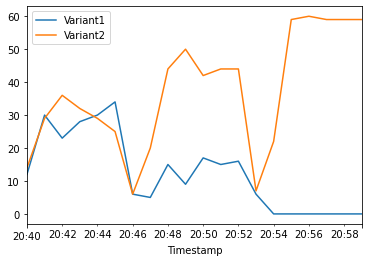

In [50]:
invoke_endpoint_for_two_minutes()
time.sleep(20)  # give metrics time to catch up
plot_endpoint_metrics(invocation_start_time)

In [52]:
sm_session.delete_endpoint(endpoint_name)